## Week6 LogisticRegression
In week 6, we've covered:
* Logistic regression
* Imbalanced Data Sets

Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a **TODO**.

Upload **Week6_LogisticRegression_Homework.ipynb**, **train.csv** and **test.csv** to Google Drive.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

ValueError: The domain policy has disabled Drive File Stream: https://support.google.com/a/answer/7496409

**TODO**: Replace **`YourFolderName`**  below with the folder name on your google drive where you put the `housing.csv` file. Run the cell, check if `train.csv` and `test.csv` is listed.

In [ ]:
#!ls /content/drive/My\ Drive/Homegrown_examples

Alternative method to upload if mounting drive doesn't work

In [2]:
from google.colab import files
uploaded = files.upload()

Saving test (1).csv to test (1).csv
Saving train.csv to train.csv


## 1. Introduction

### E-commerce Website Conversion Prediction Dataset

#### Overview
This dataset contains user session data from an e-commerce website, designed to predict whether a visitor will convert (make a purchase) during their session. This is a classic **binary classification problem** with **significant class imbalance** - only about 5% of visitors actually convert.

### Dataset Features

#### Target Variable
- **`converted`**: Binary target variable (0 = No conversion, 1 = Conversion)
  - **Class imbalance**: ~95% non-conversions, ~5% conversions
  - This imbalance makes it a perfect dataset for practicing sampling techniques

### Features

#### User Demographics
- **`age`**: User's age in years (18-75)
- **`income`**: User's annual income in USD

#### Session Characteristics
- **`session_id`**: Unique identifier for each session
- **`device_type`**: Device used to access the site (`desktop`, `mobile`, `tablet`)
- **`traffic_source`**: How the user found the website (`organic`, `paid_search`, `social`, `email`, `direct`, `referral`)
- **`pages_viewed`**: Number of pages viewed during the session
- **`session_duration_seconds`**: Time spent on the site in seconds
- **`day_of_week`**: Day of the week (0 = Monday, 6 = Sunday)
- **`previous_visits`**: Number of previous visits to the site


## 2. Exploring the data

In [9]:
import pandas as pd
import io

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head(5)

,session_id,age,income,device_type,traffic_source,pages_viewed,session_duration_seconds,day_of_week,previous_visits,converted
0,sess_000001,40,57673,desktop,paid_search,6,65,2,2,0
1,sess_000002,33,45886,mobile,email,4,448,2,1,0
2,sess_000003,42,73004,desktop,organic,3,103,0,2,0
3,sess_000004,53,94480,mobile,organic,1,338,6,1,0
4,sess_000005,32,55750,desktop,referral,5,56,2,0,0


In [12]:
train_data.info()
train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   session_id                50000 non-null  object
 1   age                       50000 non-null  int64 
 2   income                    50000 non-null  int64 
 3   device_type               50000 non-null  object
 4   traffic_source            50000 non-null  object
 5   pages_viewed              50000 non-null  int64 
 6   session_duration_seconds  50000 non-null  int64 
 7   day_of_week               50000 non-null  int64 
 8   previous_visits           50000 non-null  int64 
 9   converted                 50000 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 3.8+ MB


,0
session_id,0
age,0
income,0
device_type,0
traffic_source,0
pages_viewed,0
session_duration_seconds,0
day_of_week,0
previous_visits,0
converted,0


In [18]:
conversion_rate = train_data['converted'].mean()
print(f"Conversion Rate: {conversion_rate:.2%}")
print(train_data['converted'].value_counts())
print(train_data['converted'].value_counts(normalize=True) * 100)


Conversion Rate: 4.93%
converted
0    47537
1     2463
Name: count, dtype: int64
converted
0    95.074
1     4.926
Name: proportion, dtype: float64


In [20]:
train_data.describe()

,age,income,pages_viewed,session_duration_seconds,day_of_week,previous_visits,converted
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.960680,49371.303220,3.995360,179.751960,2.674220,2.002680,0.049260
std,11.130625,19640.167894,1.726673,179.662143,1.862975,1.408898,0.216413
min,18.000000,20000.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,33906.500000,3.000000,51.000000,1.000000,1.000000,0.000000
50%,35.000000,48582.000000,4.000000,125.000000,3.000000,2.000000,0.000000
75%,43.000000,63035.250000,5.000000,248.000000,4.000000,3.000000,0.000000
max,75.000000,126904.000000,13.000000,2024.000000,6.000000,11.000000,1.000000


In [22]:
for col in train_data.select_dtypes(include=['object', 'category']).columns:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {train_data[col].nunique()}")
    print("Value counts:")
    print(train_data[col].value_counts())



Column: session_id
Number of unique values: 50000
Value counts:
session_id
sess_049984    1
sess_049983    1
sess_049982    1
sess_049981    1
sess_049980    1
              ..
sess_000005    1
sess_000004    1
sess_000003    1
sess_000002    1
sess_000001    1
Name: count, Length: 50000, dtype: int64

Column: device_type
Number of unique values: 3
Value counts:
device_type
mobile     22603
desktop    22310
tablet      5087
Name: count, dtype: int64

Column: traffic_source
Number of unique values: 6
Value counts:
traffic_source
organic        17468
paid_search    12403
social          7546
email           5006
direct          5003
referral        2574
Name: count, dtype: int64


## 3. Baseline Logistic Regression


In [24]:
X_train = train_data.drop(columns=['converted', 'session_id'])
y_train = train_data['converted']
X_test = test_data.drop(columns=['converted', 'session_id'])
y_test = test_data['converted']


In [25]:
from sklearn.preprocessing import LabelEncoder

X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for col in X_train_enc.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_enc[col])
    X_test_enc[col] = le.transform(X_test_enc[col])


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)


In [27]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)

# Fit the logistic regression model
baseline_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [28]:
y_pred = baseline_model.predict(X_test_scaled)
import pandas as pd
actual_counts = pd.Series(y_test).value_counts()
pred_counts = pd.Series(y_pred).value_counts()
print(actual_counts)
print(pred_counts)


converted
0    14256
1      744
Name: count, dtype: int64
0    15000
Name: count, dtype: int64


## 4. Baseline Model Evaluation

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.9504
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
 [[14256     0]
 [  744     0]]


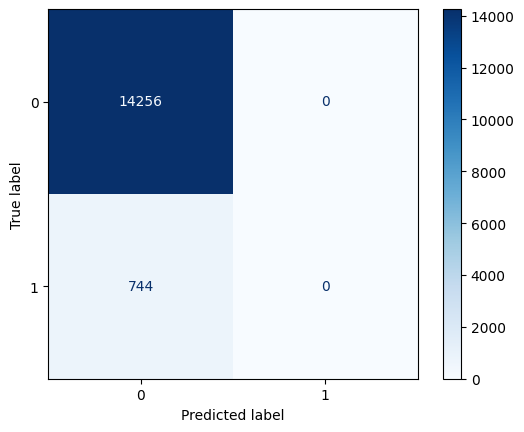

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

# Optional: nicer display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_model.classes_)
disp.plot(cmap="Blues")

How is the baseline model's performing?

It didnn't predict that any values would return a 1, so while the accuracy score is strong, the precision score is low


## 5. Addressing the Class Imbalnce

In [31]:
!pip install imbalanced-learn

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [ ]:
print("=== RANDOM OVERSAMPLING ===")

ros = RandomOverSampler(random_state=42)

# TODO: Apply fit_resample to X_train_scaled and y_train
# TODO: Print the before/after sizes and class distributions

=== RANDOM OVERSAMPLING ===


In [33]:
print("=== RANDOM UNDERSAMPLING ===")

ros = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

print(f"Before resampling: {X_train_scaled.shape}, {y_train.shape}")
print(f"After resampling : {X_resampled.shape}, {y_resampled.shape}")

print("\nBefore resampling (class counts):")
print(y_train.value_counts())

print("\nAfter resampling (class counts):")
print(pd.Series(y_resampled).value_counts())

=== RANDOM UNDERSAMPLING ===
Before resampling: (50000, 8), (50000,)
After resampling : (4926, 8), (4926,)

Before resampling (class counts):
converted
0    47537
1     2463
Name: count, dtype: int64

After resampling (class counts):
converted
0    2463
1    2463
Name: count, dtype: int64


In [34]:
print("=== SMOTE OVERSAMPLING ===")

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE: {X_train_scaled.shape}, {y_train.shape}")
print(f"After SMOTE : {X_resampled.shape}, {y_resampled.shape}")

print("\nBefore SMOTE (class counts):")
print(y_train.value_counts())

print("\nAfter SMOTE (class counts):")
print(pd.Series(y_resampled).value_counts())

=== SMOTE OVERSAMPLING ===
Before SMOTE: (50000, 8), (50000,)
After SMOTE : (95074, 8), (95074,)

Before SMOTE (class counts):
converted
0    47537
1     2463
Name: count, dtype: int64

After SMOTE (class counts):
converted
0    47537
1    47537
Name: count, dtype: int64


In [35]:
def summarize_dataset(name, X, y):
    counts = pd.Series(y).value_counts()
    total = len(y)
    class_0 = counts.get(0, 0)
    class_1 = counts.get(1, 0)
    balance_ratio = class_1 / class_0 if class_0 > 0 else float('inf')
    return {
        "Method": name,
        "Total Size": total,
        "Class 0 Count": class_0,
        "Class 1 Count": class_1,
        "Balance Ratio (1/0)": round(balance_ratio, 2)
    }

results = []
results.append(summarize_dataset("Original", X_train_scaled, y_train))
results.append(summarize_dataset("Random Oversampling", X_resampled_ros, y_resampled_ros))
results.append(summarize_dataset("SMOTE", X_resampled_smote, y_resampled_smote))
comparison_df = pd.DataFrame(results)

print("\n=== Sampling Comparison Table ===")
print(comparison_df)

NameError: name 'X_resampled_ros' is not defined

## 6. Balanced Models

In [37]:


model_ros = LogisticRegression(random_state=42, max_iter=1000)

# Fit on resampled training data
model_ros.fit(X_resampled, y_resampled)

# Make predictions on the original test set
y_pred_ros = model_ros.predict(X_test_scaled)

print("Training complete. Predictions generated.")


Training complete. Predictions generated.


In [39]:
print("=== TRAINING MODEL WITH RANDOM UNDERSAMPLING ===")

model_rus = LogisticRegression(random_state=42, max_iter=1000)

model_rus.fit(X_resampled, y_resampled)

y_pred_rus = model_rus.predict(X_test_scaled)

print("Training complete. Predictions generated.")


=== TRAINING MODEL WITH RANDOM UNDERSAMPLING ===
Training complete. Predictions generated.


In [41]:
print("=== TRAINING MODEL WITH SMOTE ===")

model_smote = LogisticRegression(random_state=42, max_iter=1000)

# Fit on SMOTE-resampled training data
model_smote.fit(X_resampled, y_resampled)

# Make predictions on the original test set
y_pred_smote = model_smote.predict(X_test_scaled)

print("Training complete. Predictions generated.")


=== TRAINING MODEL WITH SMOTE ===
Training complete. Predictions generated.


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import pandas as pd

def evaluate_model(name, y_true, y_pred, y_proba=None):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba) if y_proba is not None else None
    }

results = []

# Baseline
results.append(evaluate_model(
    "Baseline", y_test, y_pred,
    baseline_model.predict_proba(X_test_scaled)[:, 1]
))

# Random Oversampling
results.append(evaluate_model(
    "ROS", y_test, y_pred_ros,
    model_ros.predict_proba(X_test_scaled)[:, 1]
))

# Random Undersampling
results.append(evaluate_model(
    "RUS", y_test, y_pred_rus,
    model_rus.predict_proba(X_test_scaled)[:, 1]
))

# SMOTE
results.append(evaluate_model(
    "SMOTE", y_test, y_pred_smote,
    model_smote.predict_proba(X_test_scaled)[:, 1]
))

# Convert to DataFrame for pretty display
metrics_df = pd.DataFrame(results)
print("\n=== Model Performance Comparison ===")



=== Model Performance Comparison ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Compare the model performance. What model performs the best?

need help
